In [1]:
import sys
sys.path.append(r"C:\Users\Uer\Documents\JN\data_proc_from_scratch\nlp")
sys.path.append(r"C:\Users\Uer\Documents\JN\torch_custom_utils")

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset

import numpy as np
import csv

from grapheme_parsing import *
from train_eval_tools import Trainer

from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

In [3]:
PAD_TOKEN = '<PAD>'
TRAIN_SIZE_RATIO = .7
MAX_SENTENCE_LEN = 20
NEGATIVE_SAMPLE_SIZE = 25
CONTEXT_LENGHT = 5

In [4]:
with open('../stepik-dl-nlp/datasets/nyt-ingredients-snapshot-2015.csv', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter=',')
    dataset = [row[1] for row in reader]
    

In [5]:
dataset = dataset[1:]
dataset[:10]

['1 1/4 cups cooked and pureed fresh butternut squash, or 1 10-ounce package frozen squash, defrosted',
 '1 cup peeled and cooked fresh chestnuts (about 20), or 1 cup canned, unsweetened chestnuts',
 '1 medium-size onion, peeled and chopped',
 '2 stalks celery, chopped coarse',
 '1 1/2 tablespoons vegetable oil',
 '',
 '2 tablespoons unflavored gelatin, dissolved in 1/2 cup water',
 'Salt',
 '1 cup canned plum tomatoes with juice',
 '6 cups veal or beef stock']

In [6]:
train_size = int(len(dataset)*TRAIN_SIZE_RATIO)

In [7]:
train_dataset = dataset[:train_size]
eval_dataset = dataset[train_size:]
print('Size of training dataset', train_size)
print('Size of evaluation dataset', len(dataset)-train_size)

Size of training dataset 125444
Size of evaluation dataset 53763


In [8]:
train_corp = tokenize_corprus(train_dataset, token_min_len=2)
eval_corp = tokenize_corprus(eval_dataset, token_min_len=2)

In [9]:
vocabulary, token_freq = build_vocabulary(train_corp, fake_token='<PAD>')

In [10]:
len(vocabulary)

2257

In [11]:
print('\n'.join(' '.join(doc) for doc in train_corp[:10]))

cups cooked and pureed fresh butternut squash ounce package frozen squash defrosted
cup peeled and cooked fresh chestnuts about cup canned unsweetened chestnuts
medium size onion peeled and chopped
stalks celery chopped coarse
tablespoons vegetable oil

tablespoons unflavored gelatin dissolved cup water
salt
cup canned plum tomatoes with juice
cups veal beef stock


In [12]:
train_encoded = corp_encode(train_corp, vocabulary)
eval_encoded =  corp_encode(eval_corp, vocabulary)
train_encoded[:10]

[[2249, 2140, 2254, 1516, 2247, 1772, 1968, 2188, 1938, 2055, 1968, 1597],
 [2256, 2241, 2254, 2140, 2247, 1674, 2228, 2256, 2162, 1947, 1674],
 [2217, 2129, 2220, 2241, 2254, 2252],
 [1998, 2163, 2252, 2147],
 [2255, 2193, 2246],
 [],
 [2255, 1691, 1807, 1498, 2256, 2210],
 [2251],
 [2256, 2162, 2066, 2203, 2167, 2223],
 [2249, 2026, 2099, 2179]]

In [13]:
def w2v_window_parse(encoded_dataset):
    features = []
    targets = []
    window_side_size = (CONTEXT_LENGHT-1)//2
    for doc in encoded_dataset:
        padded_doc = [vocabulary[PAD_TOKEN]]*window_side_size + doc + [vocabulary[PAD_TOKEN]]*window_side_size
        for i in range(len(doc)):
            features.append(padded_doc[i+window_side_size])
            targets.append(padded_doc[i:i+window_side_size]+padded_doc[i+window_side_size+1: i+2*window_side_size+1])
    return features, targets

In [14]:
train_features, train_targets = w2v_window_parse(train_encoded)

In [15]:
eval_features, eval_targets = w2v_window_parse(eval_encoded)

In [16]:
class GeneralDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.long)
        targets = torch.tensor(self.targets[idx], dtype=torch.long)
        return (features, targets)

In [17]:
train_dataset = GeneralDataset(train_features, train_targets)
eval_dataset = GeneralDataset(eval_features, eval_targets)

In [18]:
train_dataset[:3]

(tensor([2249, 2140, 2254]),
 tensor([[   0,    0, 2140, 2254],
         [   0, 2249, 2254, 1516],
         [2249, 2140, 1516, 2247]]))

In [19]:
class Custom_SkipGram(nn.Module):
    def __init__(self, vocabulary, embedding_size, context_len=5, padding_idx=0):
        super().__init__()

        self.vocabulary = vocabulary
        self.context_len = context_len

        emb_var_range = (-1/embedding_size, 1/embedding_size)

        self.center_embeddings = nn.Embedding(len(self.vocabulary), embedding_size, padding_idx)
        self.context_embeddings = nn.Embedding(len(self.vocabulary), embedding_size, padding_idx)

        self.center_embeddings.weight.data.uniform_(*emb_var_range)
        self.context_embeddings.weight.data.uniform_(*emb_var_range)

        self.center_embeddings.weight.data[padding_idx] = 0
        self.context_embeddings.weight.data[padding_idx] = 0        
    
    def forward(self, words_vector_batch):
        """
        words_vector_batch: batch_size x 1 -- vector of word-ids
        """
        # batch_size x emb_size
        input_emb = self.center_embeddings(words_vector_batch)       
        # batch_size x vocab_size
        linear_transformation = torch.matmul(input_emb, self.context_embeddings.weight.data.T)
        # meditate upon how to mask same_word x same_word
        probs = torch.sigmoid(linear_transformation)
                        
        return probs


In [20]:
def no_loss(pred, target):
    return pred

In [21]:
model = Custom_SkipGram(vocabulary, embedding_size=100, context_len=CONTEXT_LENGHT)

In [22]:
decoder = {id: key for key, id in model.vocabulary.items()}

In [23]:
test_words = ['salad', 'fish', 'salmon', 'sauvignon', 'beef', 'pork', 'steak', 'beer', 'cake', 'coffee', 'sausage', 'wine', 'merlot', 'zinfandel', 'trout', 'chardonnay', 'champagne', 'cacao']
test_ids = [model.vocabulary[word] for word in test_words]

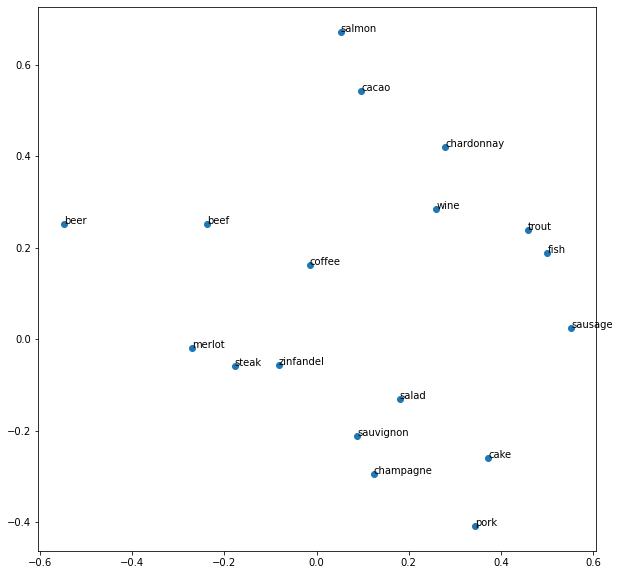

In [25]:
embs = model.center_embeddings.weight.detach().cpu().numpy()
embs /= (np.linalg.norm(embs, axis=-1, keepdims=True)+ 1e-4)
word_embs = embs[test_ids]

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
projections = TruncatedSVD().fit_transform(word_embs)
x, y = projections[:, 0], projections[:, 1]
ax.scatter(x, y)
for cur_x, cur_y, cur_label in zip(x, y, test_words):
        ax.annotate(cur_label, (cur_x, cur_y))

In [26]:
def w2v_NegSample_BCE_loss(pred, target):
    """
    Cross entropy loss for w2v model with negative sample feature.

    Parameters:
        pred - batch_size x vocab_size

        target - batch_size x (context_size-1)
    
    Return:
        loss
    """
    target_matrix = np.zeros(pred.shape)
    np.put_along_axis(target_matrix, target.cpu().numpy(), 1, axis=1)

    # put mask negative sample into global constant
    mask_ids = np.random.choice(pred.shape[1], size=(pred.shape[0], NEGATIVE_SAMPLE_SIZE))
    ns_mask = np.zeros(shape=pred.shape)
    np.put_along_axis(ns_mask, mask_ids, 1, axis=1)
    random_mask_tensor = torch.from_numpy(ns_mask).bool().to(pred.device)
    target_tensor = torch.tensor(target_matrix, dtype=torch.float).to(pred.device)

    ns_target = target_tensor[(target_tensor == 1.0) | random_mask_tensor].reshape(1, -1)
    ns_preds = pred[(target_tensor == 1.0) | random_mask_tensor].reshape(1, -1)
    loss = torch.nn.functional.binary_cross_entropy(ns_preds, ns_target)

    return loss

In [27]:
lr_scheduler_init = lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True)

In [28]:
loss_foo = w2v_NegSample_BCE_loss

In [29]:
trainer = Trainer(model, loss_foo, lr=0.01, lr_scheduler_class=lr_scheduler_init, optimizer_class=torch.optim.Adam)

In [30]:
trainer.train_eval_procedure(train_dataset, eval_dataset, batch_size=100, max_epochs=10, verbose=True)

Epoch number: 0
Epoch training done.
Training time: 55.179443
Mean training loss: 0.6814373538098828
Epoch evaluation done.
Mean evaluation loss: 0.6775220287306164
New best model!

Epoch number: 1
Epoch training done.
Training time: 53.882995
Mean training loss: 0.6727876745409773
Epoch evaluation done.
Mean evaluation loss: 0.6737326416622829
New best model!

Epoch number: 2
Epoch training done.
Training time: 52.914
Mean training loss: 0.6700944656918862
Epoch evaluation done.
Mean evaluation loss: 0.6721029812577127
New best model!

Epoch number: 3
Epoch training done.
Training time: 53.590004
Mean training loss: 0.6688867956734524
Epoch evaluation done.
Mean evaluation loss: 0.6711502647018198
New best model!

Epoch number: 4
Epoch training done.
Training time: 52.234999
Mean training loss: 0.6680395152575955
Epoch evaluation done.
Mean evaluation loss: 0.6706251380919236
New best model!

Epoch number: 5
Epoch training done.
Training time: 52.302001
Mean training loss: 0.667584846

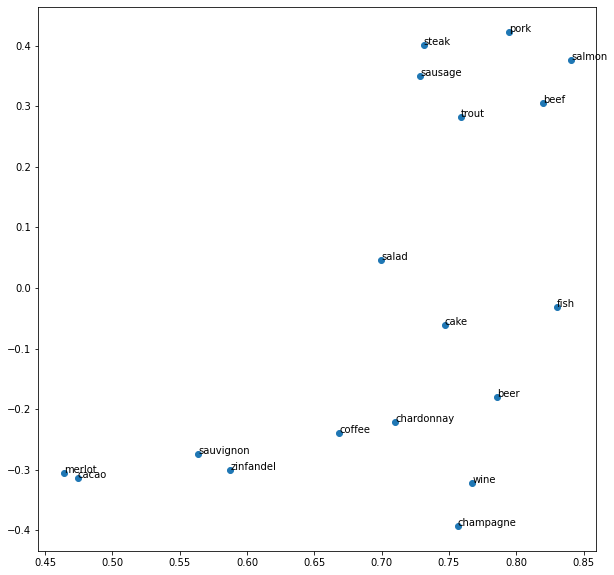

In [31]:
embs = model.center_embeddings.weight.detach().cpu().numpy()
embs /= (np.linalg.norm(embs, axis=-1, keepdims=True)+ 1e-4)
word_embs = embs[test_ids]

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
projections = TruncatedSVD().fit_transform(word_embs)
x, y = projections[:, 0], projections[:, 1]
ax.scatter(x, y)
for cur_x, cur_y, cur_label in zip(x, y, test_words):
        ax.annotate(cur_label, (cur_x, cur_y))